<img src='pics/otus.png'>

In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Кластеризация - кейс

# Данные

https://www.kaggle.com/carrie1/ecommerce-data

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

In [3]:
df = pd.read_csv('data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [24]:
df[:1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.00,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.00,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.00,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.00,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.00,United Kingdom


In [6]:
# Дубликаты
df.duplicated().sum()

5268

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      536641 non-null object
StockCode      536641 non-null object
Description    535187 non-null object
Quantity       536641 non-null int64
InvoiceDate    536641 non-null datetime64[ns]
UnitPrice      536641 non-null float64
CustomerID     401604 non-null float64
Country        536641 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description**: Product (item) name. Nominal.  
**Quantity**: The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.   
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.  
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country**: Country name. Nominal, the name of the country where each customer resides.  



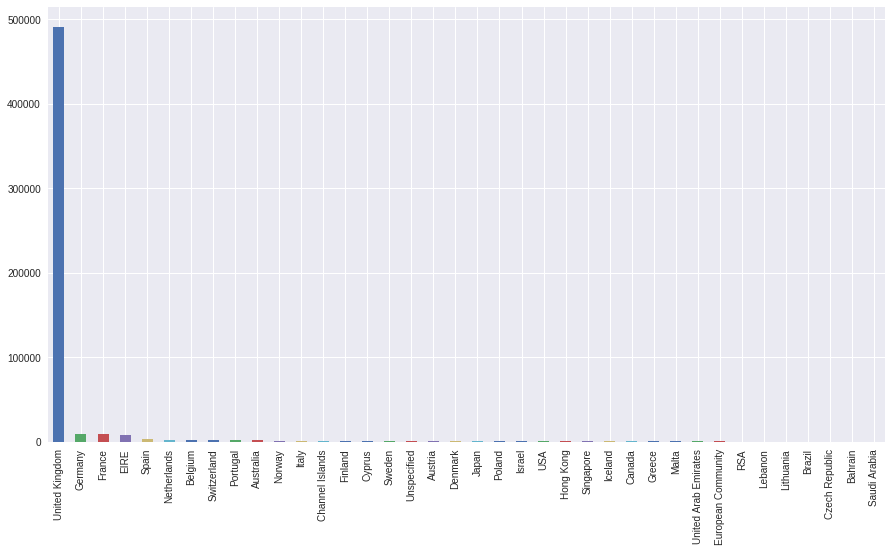

In [9]:
df.Country.value_counts().plot.bar()

In [10]:
# покупатели
df.CustomerID.unique().shape

(4373,)

In [11]:
# Заказы
df.InvoiceNo.unique().shape

(25900,)

In [12]:
# Продукты
df.StockCode.unique().shape

(4070,)

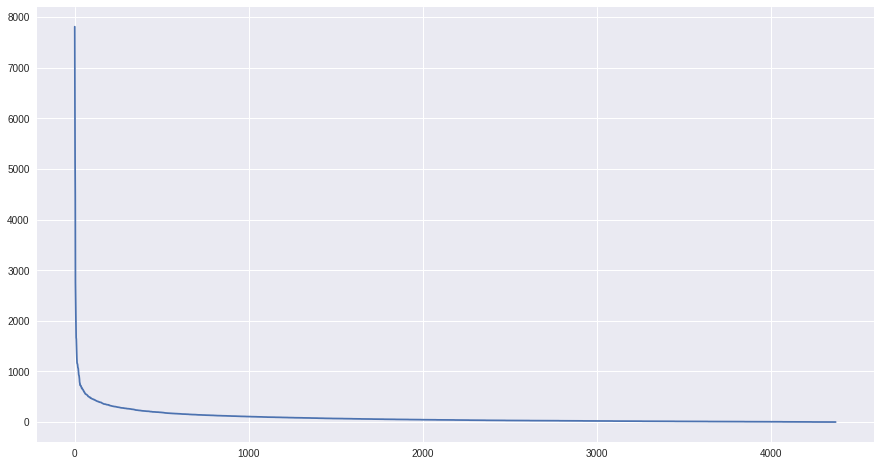

In [13]:
# Сколько заказов сделали пользователи?
counts_df = df[['CustomerID', 'InvoiceNo']].groupby('CustomerID').agg('count').sort_values(by=['InvoiceNo'], ascending=False)
counts = counts_df.as_matrix()
plt.plot(counts)

In [16]:
counts[-1000:]

array([[16],
       [16],
       [16],
       [16],
       [16],
       [16],
       [16],
       [16],
       [16],
       [16],
       [16],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [15],
       [14],
       [14],
       [14],

In [17]:
df[df['CustomerID'] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.00,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.00,United Kingdom


In [18]:
counts_df.describe()

,InvoiceNo
count,4372.00
mean,91.86
std,229.22
min,1.00
25%,17.00
50%,41.00
75%,99.25
max,7812.00


In [19]:
np.where(counts == 1)[0].shape

(79,)

In [20]:
del counts
del counts_df

# Продукты

In [29]:
import re

letters = re.compile(r'[^A-Z ]+')
spaces = re.compile('  +')

def tokenize(row):
    row = letters.sub('', row)
    row = spaces.sub(' ', row)
    return row

print(tokenize('PAPER CRAFT , LITTLE BIRDIE'))
print(tokenize('????damages????'))
print(tokenize('CREAM HANGING HEART T-LIGHT HOLDER'))

PAPER CRAFT LITTLE BIRDIE

CREAM HANGING HEART TLIGHT HOLDER


In [30]:
df['DescriptionCleaned'] = df['Description'].replace(np.nan, '').apply(tokenize)

In [33]:

len(df['DescriptionCleaned'].unique())

3999

# bag of words
1 - bag of bag of words  
2 - bag cupid of coat  

  bag coat cupid of words  
1  2   0     0   2   1  
2  1   1     1   1   0  


In [37]:
from collections import Counter
docs = []
word_count = Counter()
descs_unique = pd.DataFrame(df['DescriptionCleaned'].unique(), columns=['DescriptionCleaned'])
for idx, row in descs_unique.iterrows():
    desc = row['DescriptionCleaned']
    tokens = filter(None, desc.split(' '))
    docs.append(Counter(tokens))
    for t in tokens:
        
        word_count[t] += 1

In [38]:
docs[:20]

[Counter({'HANGING': 1, 'HEART': 1, 'HOLDER': 1, 'TLIGHT': 1, 'WHITE': 1}),
 Counter({'LANTERN': 1, 'METAL': 1, 'WHITE': 1}),
 Counter({'COAT': 1, 'CREAM': 1, 'CUPID': 1, 'HANGER': 1, 'HEARTS': 1}),
 Counter({'BOTTLE': 1,
          'FLAG': 1,
          'HOT': 1,
          'KNITTED': 1,
          'UNION': 1,
          'WATER': 1}),
 Counter({'HEART': 1, 'HOTTIE': 1, 'RED': 1, 'WHITE': 1, 'WOOLLY': 1}),
 Counter({'BABUSHKA': 1, 'BOXES': 1, 'NESTING': 1, 'SET': 1}),
 Counter({'FROSTED': 1, 'GLASS': 1, 'HOLDER': 1, 'STAR': 1, 'TLIGHT': 1}),
 Counter({'HAND': 1, 'JACK': 1, 'UNION': 1, 'WARMER': 1}),
 Counter({'DOT': 1, 'HAND': 1, 'POLKA': 1, 'RED': 1, 'WARMER': 1}),
 Counter({'ASSORTED': 1, 'BIRD': 1, 'COLOUR': 1, 'ORNAMENT': 1}),
 Counter({'BEDROOM': 1, 'PLAYHOUSE': 1, 'POPPYS': 1}),
 Counter({'KITCHEN': 1, 'PLAYHOUSE': 1, 'POPPYS': 1}),
 Counter({'CHARLOTTE': 1, 'DOLL': 1, 'FELTCRAFT': 1, 'PRINCESS': 1}),
 Counter({'COSY': 1, 'IVORY': 1, 'KNITTED': 1, 'MUG': 1}),
 Counter({'ASSORTED': 1, 

In [39]:
words_most = dict(word_count.most_common(300))
words_most

{'A': 19,
 'ACRYLIC': 20,
 'ALPHABET': 15,
 'AMBER': 13,
 'AND': 80,
 'ANT': 12,
 'ANTIQUE': 40,
 'APPLES': 13,
 'APRON': 14,
 'ART': 75,
 'ASSORTED': 59,
 'BABUSHKA': 23,
 'BAG': 168,
 'BAKING': 16,
 'BALL': 16,
 'BAROQUE': 25,
 'BASKET': 22,
 'BATHROOM': 15,
 'BEAD': 38,
 'BEADED': 15,
 'BEADS': 19,
 'BELL': 24,
 'BELLS': 16,
 'BIRD': 45,
 'BIRTHDAY': 31,
 'BLACK': 97,
 'BLING': 25,
 'BLOSSOM': 14,
 'BLUE': 205,
 'BOOK': 23,
 'BOTANICAL': 16,
 'BOTTLE': 41,
 'BOUDICCA': 12,
 'BOWL': 53,
 'BOX': 136,
 'BOXES': 19,
 'BRACELET': 68,
 'BROWN': 13,
 'BUNNY': 23,
 'BUNTING': 19,
 'BUTTERFLY': 39,
 'CABINET': 23,
 'CAKE': 82,
 'CAKES': 11,
 'CAN': 13,
 'CANDLE': 92,
 'CANDLES': 41,
 'CANDY': 15,
 'CARD': 86,
 'CARDS': 52,
 'CASES': 27,
 'CAT': 21,
 'CERAMIC': 45,
 'CHARLOTTE': 11,
 'CHARM': 39,
 'CHERRY': 15,
 'CHICK': 16,
 'CHILDRENS': 30,
 'CHILDS': 14,
 'CHOCOLATE': 26,
 'CHRISTMAS': 153,
 'CHUNKY': 13,
 'CIRCUS': 12,
 'CLASSIC': 19,
 'CLOCK': 44,
 'CM': 17,
 'COFFEE': 21,
 'COLOUR': 33,

In [40]:
docs_filtered = [{k: v for k, v in d.iteritems() if k in words_most} for d in docs]

In [41]:
docs_filtered

[{'HANGING': 1, 'HEART': 1, 'HOLDER': 1, 'TLIGHT': 1, 'WHITE': 1},
 {'LANTERN': 1, 'METAL': 1, 'WHITE': 1},
 {'CREAM': 1, 'HANGER': 1, 'HEARTS': 1},
 {'BOTTLE': 1, 'HOT': 1, 'UNION': 1, 'WATER': 1},
 {'HEART': 1, 'RED': 1, 'WHITE': 1},
 {'BABUSHKA': 1, 'BOXES': 1, 'SET': 1},
 {'GLASS': 1, 'HOLDER': 1, 'STAR': 1, 'TLIGHT': 1},
 {'HAND': 1, 'JACK': 1, 'UNION': 1, 'WARMER': 1},
 {'HAND': 1, 'RED': 1, 'WARMER': 1},
 {'ASSORTED': 1, 'BIRD': 1, 'COLOUR': 1},
 {},
 {'KITCHEN': 1},
 {'CHARLOTTE': 1, 'FELTCRAFT': 1},
 {'COSY': 1, 'IVORY': 1, 'MUG': 1},
 {'ASSORTED': 1, 'BOX': 1, 'COLOUR': 1, 'OF': 1},
 {'BOX': 1, 'JIGSAW': 1, 'OF': 1, 'VINTAGE': 1},
 {'ALPHABET': 1, 'BOX': 1, 'OF': 1, 'VINTAGE': 1},
 {'HOME': 1},
 {'LOVE': 1},
 {'BOX': 1, 'HEART': 1, 'METAL': 1, 'WITH': 1},
 {'DOORMAT': 1, 'NEW': 1},
 {'JAM': 1, 'SET': 1, 'WITH': 1},
 {'RACK': 1, 'RED': 1},
 {'RACK': 1, 'YELLOW': 1},
 {'BLUE': 1, 'RACK': 1},
 {},
 {'CLOCK': 1, 'PINK': 1},
 {'CLOCK': 1, 'RED': 1},
 {'CLOCK': 1, 'GREEN': 1},
 {'A

In [ ]:
[
    {bag: 2, of:2, words:1},
    {bag: 2, of:2, words:1},
    {bag:1, coat:1 cupid:1 of:1}
]
#  bag coat cupid of words  
#1  2   0     0   2   1  
#2  1   1     1   1   0  

In [42]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False)
X = v.fit_transform(docs_filtered)

In [46]:
X.shape

(3999, 300)

In [47]:
np.count_nonzero(X)

11560

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [49]:

inertias = []
silhs = []
for n_clusters in range(3, 15):
    
    print(n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    
    print("For n_clusters =", n_clusters, "The inertia_ is :", kmeans.inertia_, "The average silhouette_score is :", silhouette_avg)
    
    inertias.append(kmeans.inertia_)
    silhs.append(silhouette_avg)
    


3
For n_clusters = 3 The inertia_ is : 10718.8130325 The average silhouette_score is : 0.0747495216023
4
For n_clusters = 4 The inertia_ is : 10509.2901611 The average silhouette_score is : 0.0788506204989
5
For n_clusters = 5 The inertia_ is : 10391.3227154 The average silhouette_score is : 0.0842175704946
6
For n_clusters = 6 The inertia_ is : 10319.6962139 The average silhouette_score is : 0.0786824319409
7
For n_clusters = 7 The inertia_ is : 10220.1235839 The average silhouette_score is : 0.0521061780545
8
For n_clusters = 8 The inertia_ is : 9961.71389012 The average silhouette_score is : 0.0740234620027
9
For n_clusters = 9 The inertia_ is : 9921.89246125 The average silhouette_score is : 0.0714924182587
10
For n_clusters = 10 The inertia_ is : 9787.65750091 The average silhouette_score is : 0.0700017537025
11
For n_clusters = 11 The inertia_ is : 9680.57030756 The average silhouette_score is : 0.0736535914564
12
For n_clusters = 12 The inertia_ is : 9524.23735959 The average si

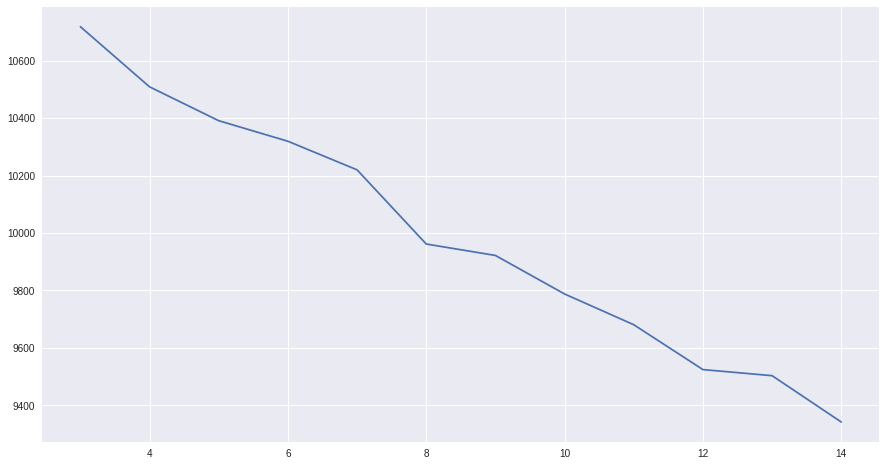

In [50]:
plt.plot(range(3, 15), inertias)

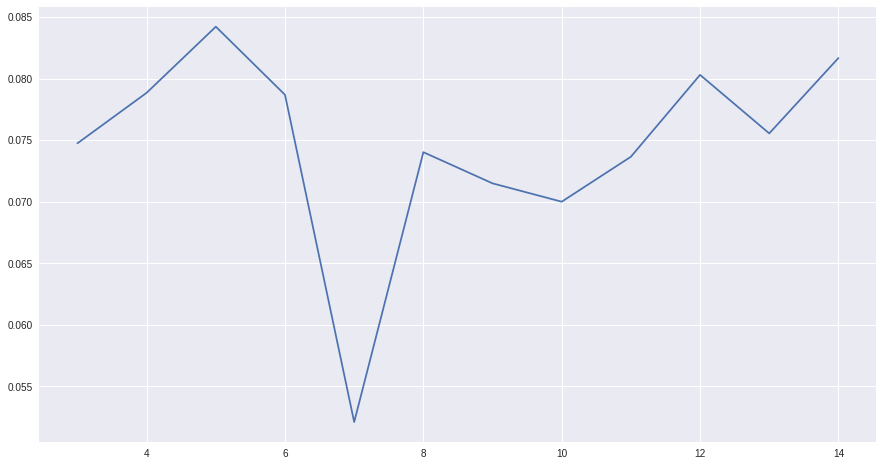

In [51]:
plt.plot(range(3, 15), silhs)

In [52]:
def clusters_stats(n_clusters, clusters, print_words=True):
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
    print(np.bincount(clusters))
    if print_words:
        cluster_words_count = defaultdict(Counter)

        for c, doc in zip(clusters, docs_filtered):
            for w in doc.keys():
                cluster_words_count[c][w] += 1

        for c in cluster_words_count:
            print('Cluster {}'.format(c))
            print(', '.join('{}: {}'.format(w, count) for w, count in cluster_words_count[c].most_common(10)))
            print()

For n_clusters = 5 The average silhouette_score is : 0.0534273198318


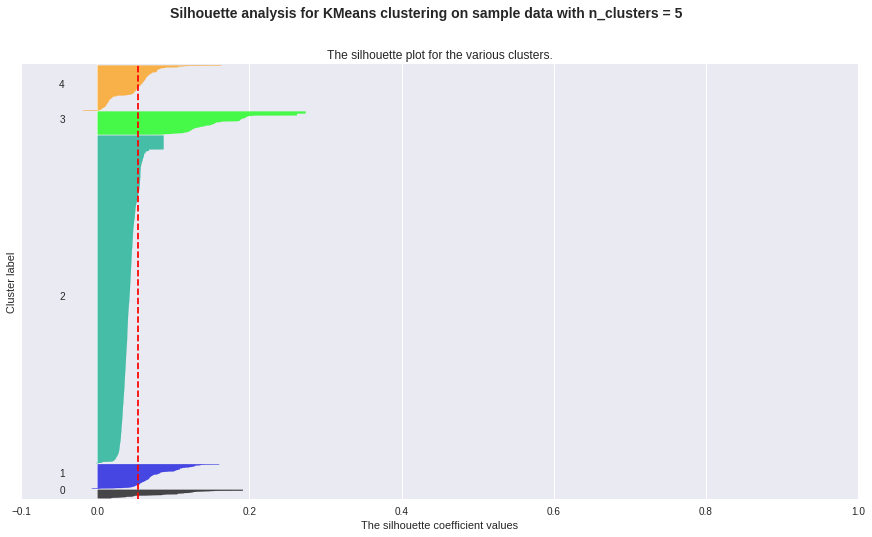

[  79  229 3057  215  419]
Cluster 0
PAPER: 79, SET: 27, LANTERN: 11, HONEYCOMB: 10, DOILIES: 10, OF: 10, STAR: 9, GARLAND: 7, RED: 6, BUNTING: 6

Cluster 1
OF: 229, SET: 134, PACK: 52, VINTAGE: 24, TISSUES: 18, CAKE: 18, TINS: 17, CASES: 13, HEART: 12, MAGNETS: 11

Cluster 2
HEART: 191, BLUE: 188, RED: 174, VINTAGE: 154, BAG: 128, CHRISTMAS: 120, WHITE: 113, BOX: 111, DESIGN: 110, HOLDER: 98

Cluster 3
SET: 215, CARDS: 34, CANDLES: 16, IMAGES: 10, CUTLERY: 10, PIECE: 10, BAG: 10, VINTAGE: 9, CHRISTMAS: 9, RED: 9

Cluster 4
PINK: 281, GLASS: 150, HEART: 29, BAG: 25, FLOWER: 22, BRACELET: 22, CHARM: 20, SMALL: 20, BEAD: 19, POLKADOT: 18



In [53]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
kmeans.inertia_
clusters_stats(n_clusters, clusters)

For n_clusters = 6 The average silhouette_score is : 0.0578813048436


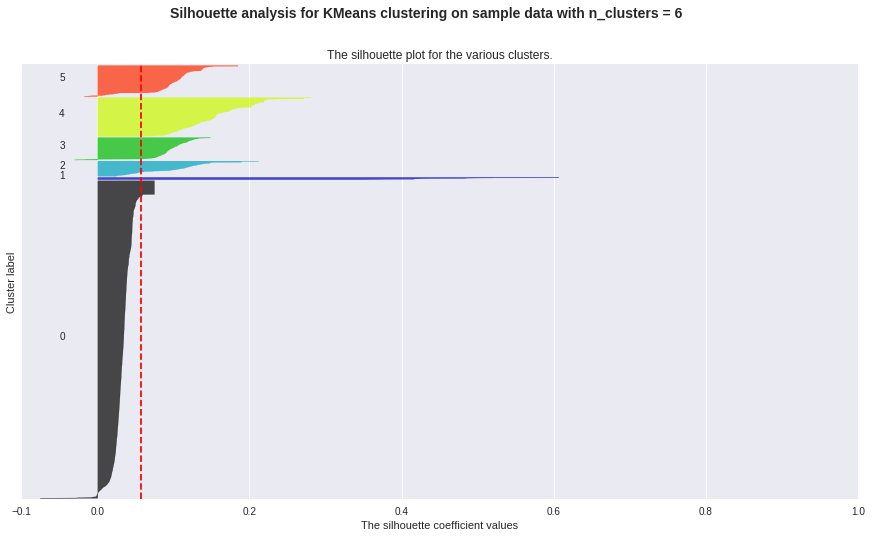

[2971   22  142  210  364  290]
Cluster 0
BLUE: 182, VINTAGE: 167, RED: 165, BAG: 143, GLASS: 123, CHRISTMAS: 120, BOX: 113, DESIGN: 111, WHITE: 103, METAL: 91

Cluster 1
HOME: 22, SWEET: 21, DOORMAT: 3, HOLDER: 2, HANGER: 2, OF: 2, STORAGE: 1, HOOK: 1, TIN: 1, WITH: 1

Cluster 2
NECKLACE: 94, MINI: 50, BLACK: 14, PENDANT: 12, SHELL: 11, W: 11, GLASS: 11, ORBIT: 9, JIGSAW: 9, BEAD: 9

Cluster 3
HEART: 210, DECORATION: 27, HANGING: 23, HOLDER: 22, SMALL: 19, LARGE: 18, TLIGHT: 18, ZINC: 17, WHITE: 17, LOVE: 16

Cluster 4
SET: 364, OF: 143, CARDS: 37, PAPER: 27, VINTAGE: 26, TINS: 19, TLIGHTS: 17, CANDLES: 17, CUTLERY: 16, CHRISTMAS: 15

Cluster 5
PINK: 290, HEART: 22, POLKADOT: 21, FLOWER: 17, BAG: 15, VINTAGE: 12, GLASS: 12, COVER: 12, FLOCK: 12, AND: 10



In [55]:
n_clusters = 6
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
kmeans.inertia_
clusters_stats(n_clusters, clusters)

In [56]:
descs_unique.shape, clusters.shape

((3999, 1), (3999,))

In [57]:
descs_unique['cluster'] = clusters

In [58]:
descs_unique.head()

,DescriptionCleaned,cluster
0,WHITE HANGING HEART TLIGHT HOLDER,3
1,WHITE METAL LANTERN,0
2,CREAM CUPID HEARTS COAT HANGER,0
3,KNITTED UNION FLAG HOT WATER BOTTLE,0
4,RED WOOLLY HOTTIE WHITE HEART,3


In [59]:
df = pd.merge(df, descs_unique, on='DescriptionCleaned', how='left')

In [60]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DescriptionCleaned,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,WHITE HANGING HEART TLIGHT HOLDER,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,WHITE METAL LANTERN,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,CREAM CUPID HEARTS COAT HANGER,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,RED WOOLLY HOTTIE WHITE HEART,3


In [61]:
df_clusters = df.cluster.as_matrix()
total_price = df.UnitPrice.as_matrix() * df.Quantity.as_matrix()

In [62]:
def get_cluster_total_spent(x, i):
    if x.cluster != i:
        return 0
    
    return x.UnitPrice * x.Quantity

for i in range(n_clusters):
    clusters_i = np.zeros(df_clusters.shape[0])
    clusters_i[df_clusters == i] = total_price[df_clusters == i]
    df['cluster_{}'.format(i)] = clusters_i

In [63]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DescriptionCleaned,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,WHITE HANGING HEART TLIGHT HOLDER,3,0.00,0.00,0.00,15.30,0.00,0.00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,WHITE METAL LANTERN,0,20.34,0.00,0.00,0.00,0.00,0.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.00,0.00,0.00,0.00,0.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.00,0.00,0.00,0.00,0.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,RED WOOLLY HOTTIE WHITE HEART,3,0.00,0.00,0.00,20.34,0.00,0.00


In [65]:
group = df[['CustomerID', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']].groupby('CustomerID').agg('sum')
group.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
CustomerID,,,,,,
12346.00,0.00,0.00,0.00,0.00,0.00,0.00
12347.00,3286.91,0.00,78.60,183.54,482.95,278.00
12348.00,1542.64,0.00,0.00,0.00,191.00,63.60
12349.00,1299.48,0.00,0.00,121.95,298.62,37.50
12350.00,334.40,0.00,0.00,0.00,0.00,0.00


In [68]:
customers = group[(group.cluster_0 != 0) | (group.cluster_1 != 0) | (group.cluster_2 != 0)]
customers.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
CustomerID,,,,,,
12347.00,3286.91,0.00,78.60,183.54,482.95,278.00
12348.00,1542.64,0.00,0.00,0.00,191.00,63.60
12349.00,1299.48,0.00,0.00,121.95,298.62,37.50
12350.00,334.40,0.00,0.00,0.00,0.00,0.00
12352.00,1090.76,0.00,0.00,54.20,257.60,142.85


In [72]:
X = customers.as_matrix()

In [73]:
X.shape

(4349, 6)

In [74]:
list(X.sum(axis=0))

[6207478.4240000006,
 79446.350000000006,
 99439.880000000005,
 581032.96999999997,
 945382.19000000018,
 363523.83000000002]

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
print('variables mean values: ', scaler.mean_)
scaled_matrix = scaler.transform(X)

variables mean values:  [ 1427.33465716    18.26772821    22.86499885   133.60151069   217.37921131
    83.58791216]


In [77]:

inertias = []
silhs = []
c_range = range(5, 15)
for n_clusters in c_range:
    
    print(n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The inertia_ is :", kmeans.inertia_, "The average silhouette_score is :", silhouette_avg)
    
    inertias.append(kmeans.inertia_)
    silhs.append(silhouette_avg)
    


5
For n_clusters = 5 The inertia_ is : 5803.3905035 The average silhouette_score is : 0.957287245988
6
For n_clusters = 6 The inertia_ is : 4652.72983317 The average silhouette_score is : 0.948479734672
7
For n_clusters = 7 The inertia_ is : 3721.37667761 The average silhouette_score is : 0.948670588928
8
For n_clusters = 8 The inertia_ is : 3030.63599131 The average silhouette_score is : 0.826662462017
9
For n_clusters = 9 The inertia_ is : 2533.93945331 The average silhouette_score is : 0.746687349059
10
For n_clusters = 10 The inertia_ is : 2300.31565155 The average silhouette_score is : 0.736139672749
11
For n_clusters = 11 The inertia_ is : 2098.61187553 The average silhouette_score is : 0.731407628
12
For n_clusters = 12 The inertia_ is : 1927.69862301 The average silhouette_score is : 0.573471565958
13
For n_clusters = 13 The inertia_ is : 1760.77471177 The average silhouette_score is : 0.574153190694
14
For n_clusters = 14 The inertia_ is : 1630.65129143 The average silhouette_

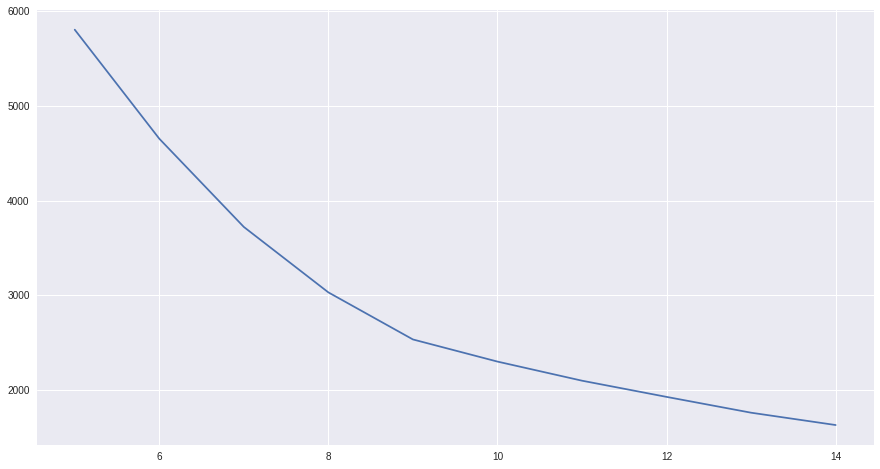

In [79]:
c_range = range(5, 15)
plt.plot(c_range, inertias)

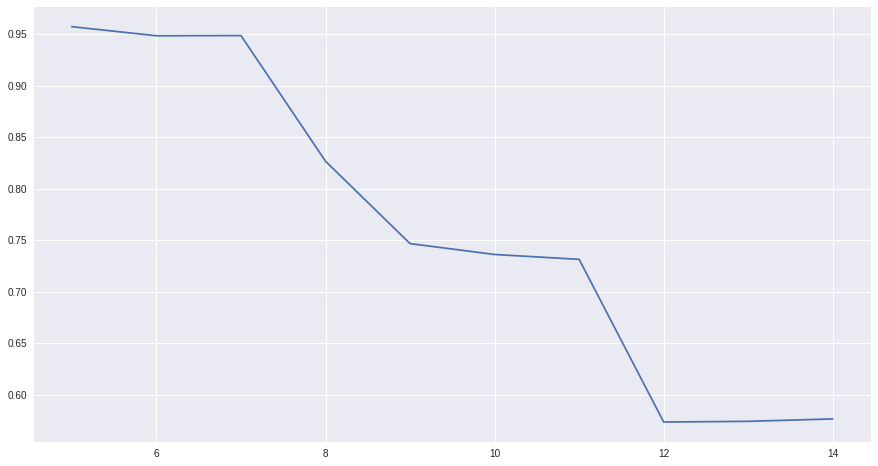

In [80]:
plt.plot(c_range, silhs)

For n_clusters = 5 The average silhouette_score is : 0.956707995305


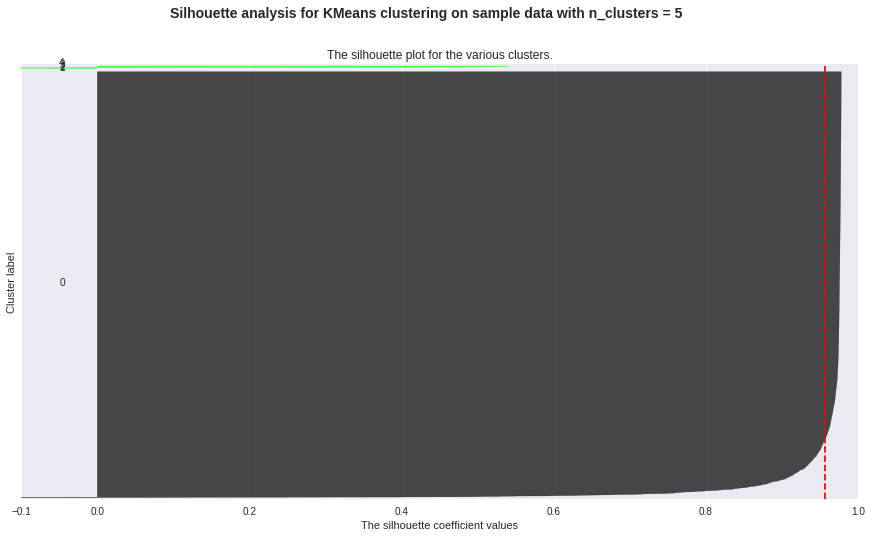

[4321    1    1   25    1]
For n_clusters = 6 The average silhouette_score is : 0.951505075039


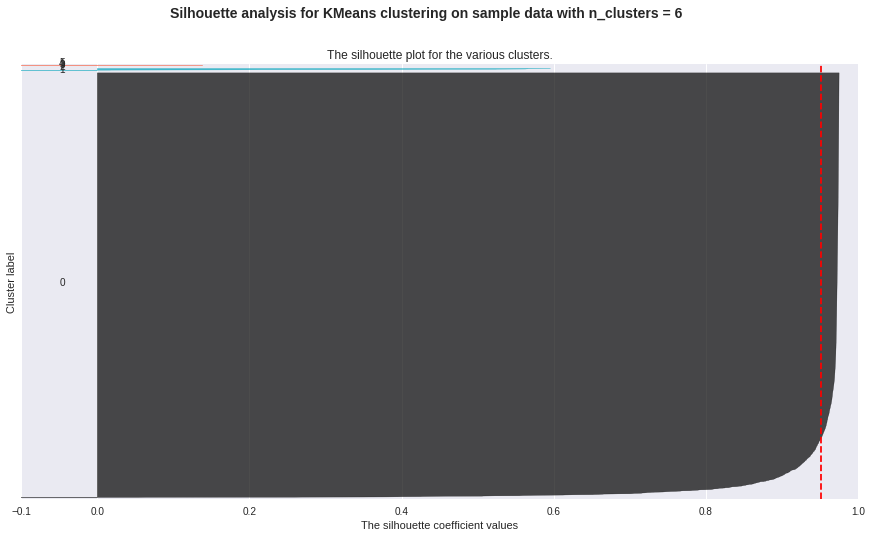

[4319    1   24    1    1    3]
For n_clusters = 7 The average silhouette_score is : 0.912222716629


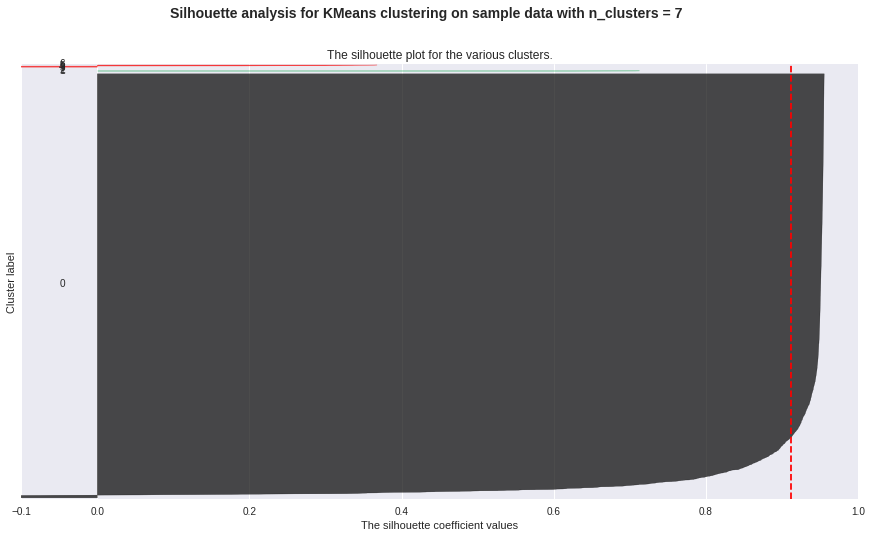

[4319    1    1    3    1    1   23]
For n_clusters = 8 The average silhouette_score is : 0.812105978698


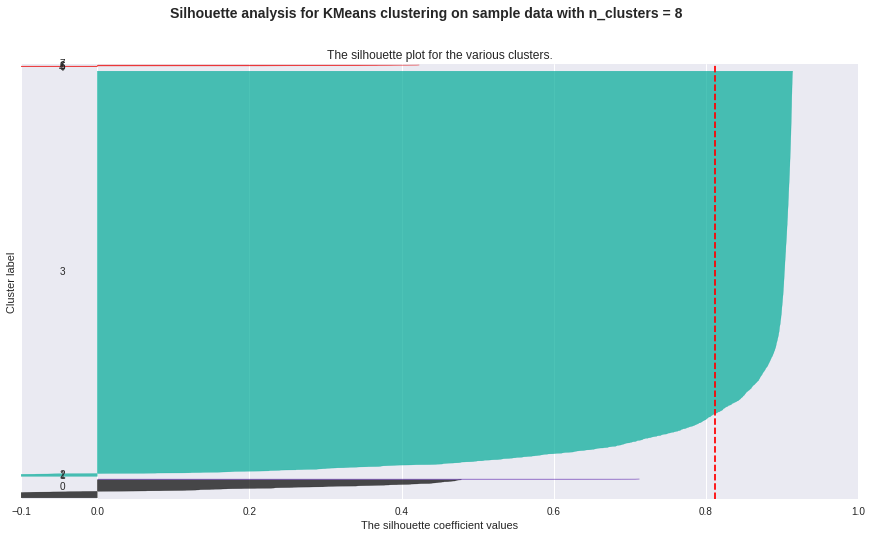

[ 185    3    1 4137    1    1    1   20]
For n_clusters = 9 The average silhouette_score is : 0.764365269227


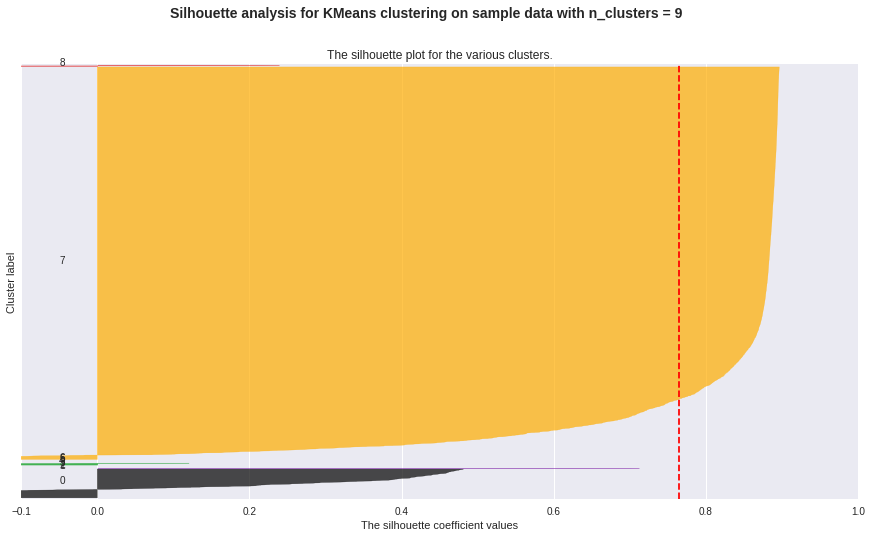

[ 295    3    1    1   21    1    1 4016   10]
For n_clusters = 10 The average silhouette_score is : 0.761208099841


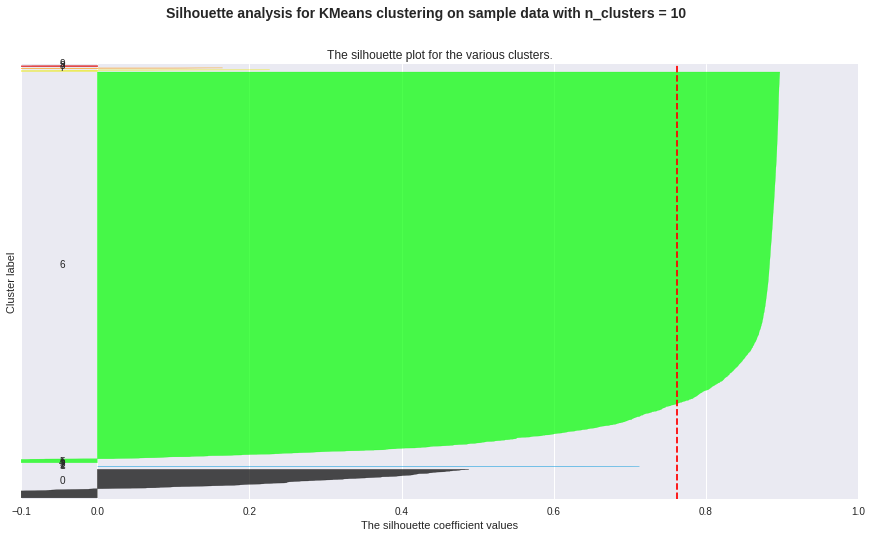

[ 293    1    1    3    1    1 4007   17   10   15]
For n_clusters = 11 The average silhouette_score is : 0.641764007514


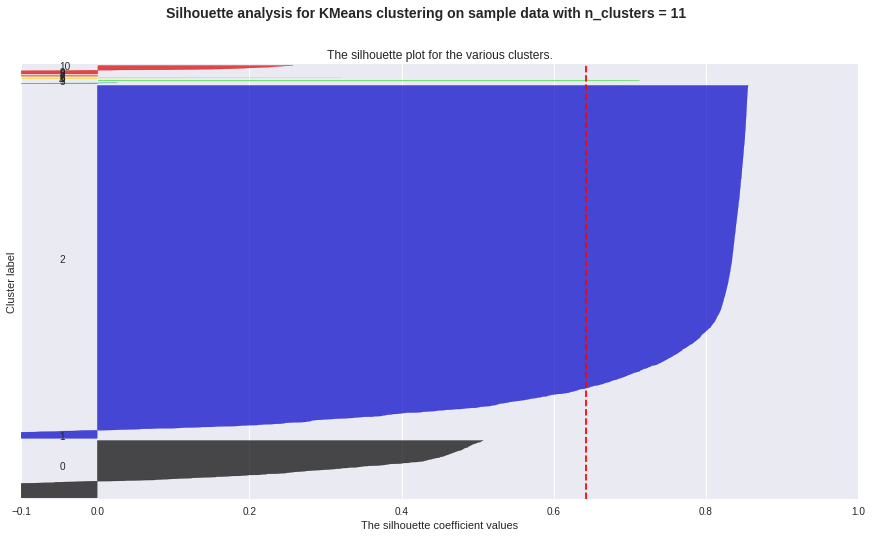

[ 590    1 3628    1   10    1    3    1   11   15   88]
For n_clusters = 12 The average silhouette_score is : 0.611040925413


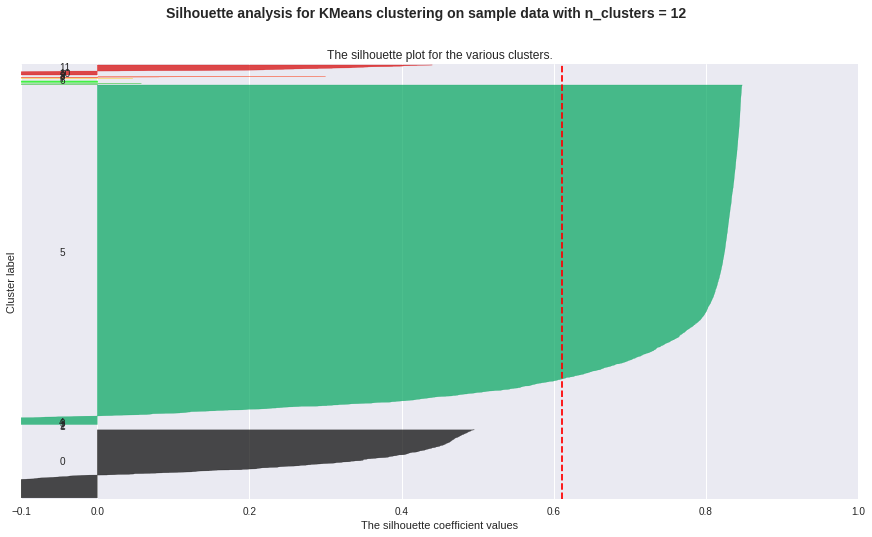

[ 701    1    1    1    1 3498   10   17    1    2   12  104]
For n_clusters = 13 The average silhouette_score is : 0.627238238822


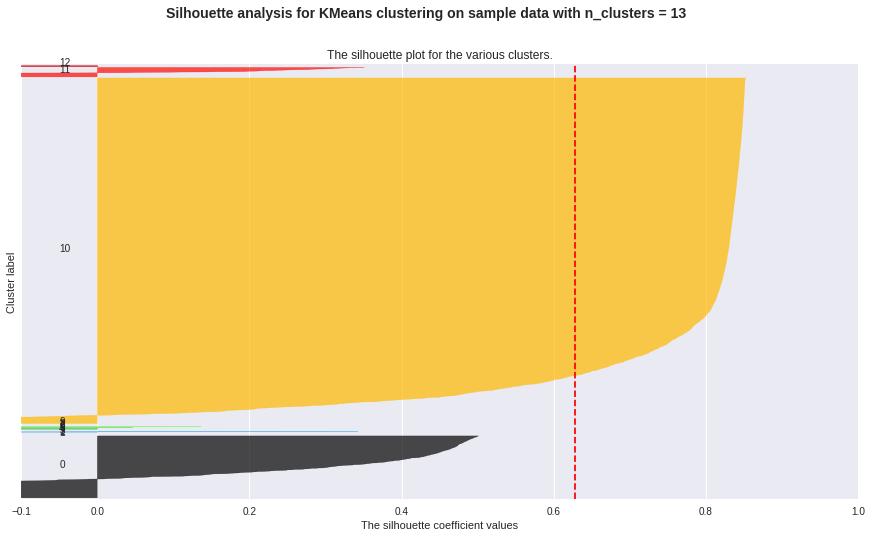

[ 640    1    1    1   10    1    7    2    3    1 3568   99   15]
For n_clusters = 14 The average silhouette_score is : 0.632337462377


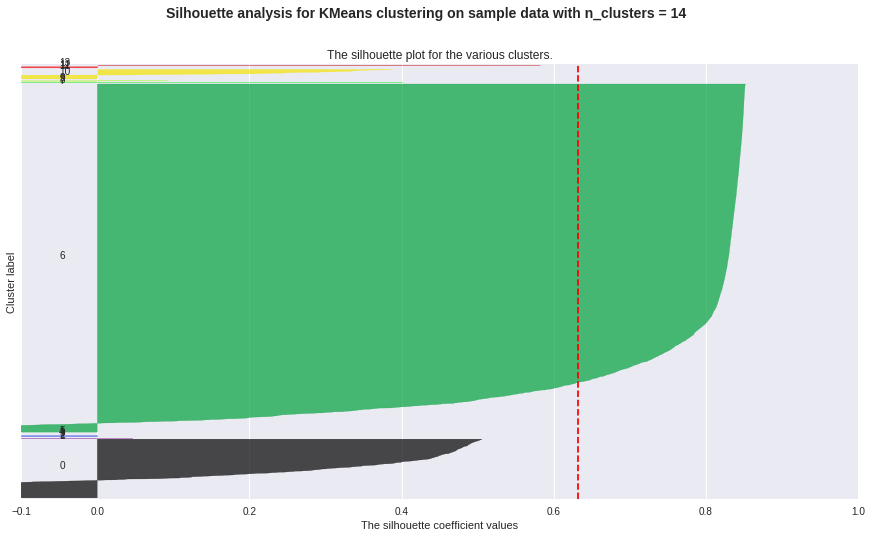

[ 608    2    1    7    1    1 3602    1    2    9   98    1   13    3]


In [82]:

for n_clusters in range(5, 15): 
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    kmeans.inertia_
    clusters_stats(n_clusters, clusters, print_words=False)

In [83]:
n_clusters = 24
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(scaled_matrix)
clusters = kmeans.predict(scaled_matrix)
kmeans.inertia_
customers_df = pd.DataFrame(customers)
customers_df['cluster'] = clusters
customers_df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster
CustomerID,,,,,,,
12347.00,3286.91,0.00,78.60,183.54,482.95,278.00,13
12348.00,1542.64,0.00,0.00,0.00,191.00,63.60,0
12349.00,1299.48,0.00,0.00,121.95,298.62,37.50,0
12350.00,334.40,0.00,0.00,0.00,0.00,0.00,0
12352.00,1090.76,0.00,0.00,54.20,257.60,142.85,10


In [67]:
cluster_meta = customers_df.groupby('cluster').agg('mean')
cluster_meta.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
cluster,,,,,,,
0,2751.90,867.36,330.17,354.52,225.95,159.98,36.92
1,36302.88,14627.88,318.96,3553.08,177.60,3627.81,713.25
2,134620.60,60218.14,3566.08,1074.00,42219.44,468.42,14271.81
3,123109.89,76790.16,6513.83,46967.28,17578.01,8414.20,115.65
4,101841.99,24309.98,2948.04,0.00,50530.34,4921.78,2770.04


In [68]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

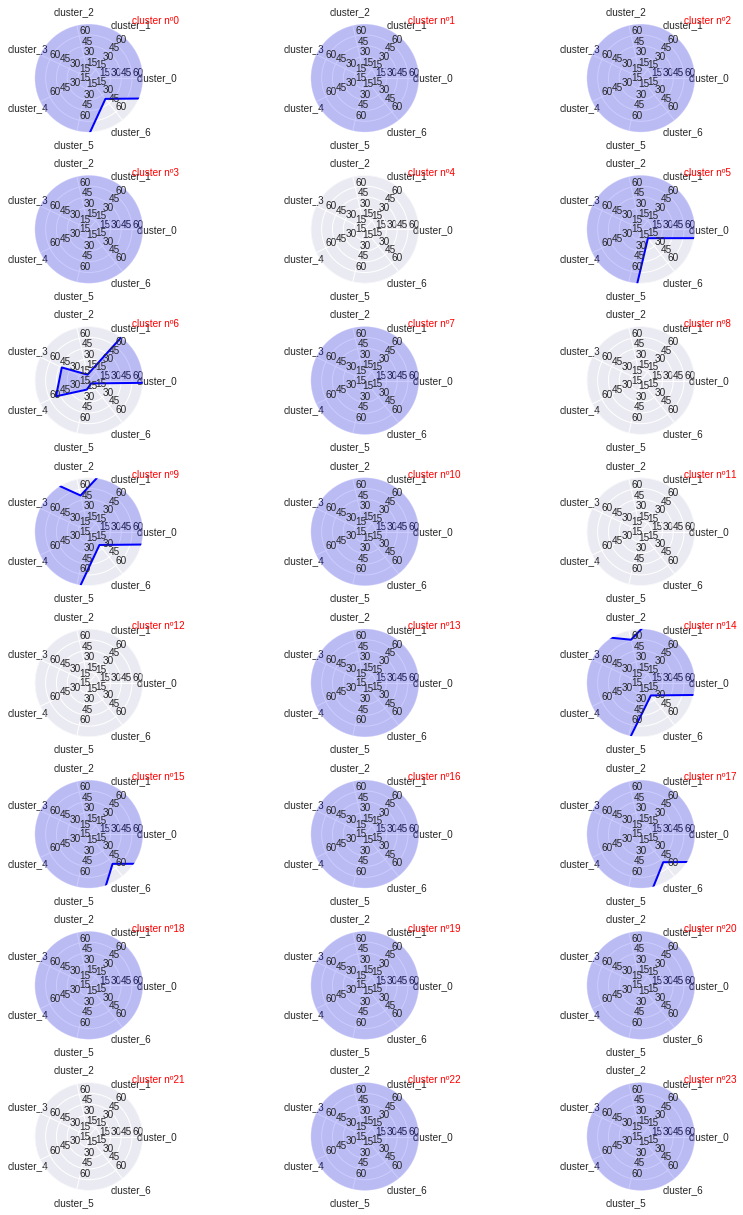

In [71]:
fig = plt.figure(figsize=(10,12))

attributes = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']
ranges = [[0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = range(30)

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1./i_cols), (1./i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(cluster_meta.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = u'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

# MCL
https://micans.org/mcl/

In [7]:
def to_set(x):
    return set(x)

def to_set_len(x):
    return len(set(x))

product_orders = df.dropna(subset = ['CustomerID'])[['StockCode', 'CustomerID']].groupby('CustomerID', as_index=False).agg([to_set, to_set_len]).reset_index()

In [8]:
product_orders.columns = ['.'.join(filter(None, pair)) for pair in zip(product_orders.columns.get_level_values(0), product_orders.columns.get_level_values(1))]
product_orders.head()

,CustomerID,StockCode.to_set,StockCode.to_set_len
0,12346.00,{23166},1
1,12347.00,"{22775, 22774, 22773, 22772, 22771, 22372, 223...",103
2,12348.00,"{21967, 84992, 84991, 22437, 21211, 21213, 229...",22
3,12349.00,"{23460, 20914, 23108, 37500, 22567, 21231, 217...",73
4,12350.00,"{21866, 21908, 21864, 79066K, 22348, 22620, 22...",17


In [9]:
l = len(product_orders[product_orders['StockCode.to_set_len'] > 0])
l*(l-1)/2.

9555006.0

In [10]:
product_orders_dict = dict(zip(product_orders.CustomerID, product_orders['StockCode.to_set']))

In [11]:
from itertools import combinations
user_pairs = list(combinations(sorted(product_orders_dict.keys()), 2))

In [12]:
user_pairs[:10]

[(12346.0, 12347.0),
 (12346.0, 12348.0),
 (12346.0, 12349.0),
 (12346.0, 12350.0),
 (12346.0, 12352.0),
 (12346.0, 12353.0),
 (12346.0, 12354.0),
 (12346.0, 12355.0),
 (12346.0, 12356.0),
 (12346.0, 12357.0)]

In [13]:
def jaccard(s1, s2):
    return len(s1 & s2) * 1. / len(s1 | s2)

In [19]:
similarities = []
for i1, i2 in user_pairs:
    j = jaccard(product_orders_dict[i1], product_orders_dict[i2])
    if j > 0:
        similarities.append((i1, i2, j))

In [20]:
len(similarities)

5082856

In [21]:
with open('similarities.txt', 'w') as f:
    for u1, u2, s in similarities:
        f.write('{}\t{}\t{}\n'.format(u1, u2, s))

In [84]:
!head similarities.txt

12346.0	12409.0	0.010989010989
12346.0	12415.0	0.00225225225225
12346.0	12433.0	0.00456621004566
12346.0	12607.0	0.00990099009901
12346.0	12688.0	0.00584795321637
12346.0	12705.0	0.00438596491228
12346.0	12748.0	0.000565291124929
12346.0	12749.0	0.00625
12346.0	12815.0	0.0263157894737
12346.0	12877.0	0.01


In [ ]:
!/home/stroykova/local/mcl/bin/mcl similarities.txt --abc -o clusters -I 2 -p 0.0015 -pct 60

In [85]:
!wc -l clusters

33 clusters
